Current quench force calculations for Next Step Fusion design
==========

**Note:** Running this example requires the [triangle](https://pypi.org/project/triangle/) python package, which is installable using `pip` or other standard methods.

In [1]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.interpolate import CubicSpline
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

### Load TokaMaker library

To load the TokaMaker python module we need to tell python where to the module is located. This can be done either through the `PYTHONPATH` environment variable or using within a script using `sys.path.append()` as below, where we look for the environement variable `OFT_ROOTPATH` to provide the path to where the OpenFUSIONToolkit is installed (`/Applications/OFT` on macOS).

For meshing we will use the \ref OpenFUSIONToolkit.TokaMaker.gs_Domain "gs_Domain()" class to build a 2D triangular grid suitable for Grad-Shafranov equilibria. This class uses the [triangle code](https://www.cs.cmu.edu/~quake/triangle.html) through a [python wrapper](https://pypi.org/project/triangle/).

In [2]:
tokamaker_python_path = os.getenv('OFT_ROOTPATH')
if tokamaker_python_path is not None:
    sys.path.append(os.path.join(tokamaker_python_path,'python'))
sys.path.append('/Applications/OpenFUSIONToolkit/python')
from OpenFUSIONToolkit.TokaMaker import TokaMaker
from OpenFUSIONToolkit.TokaMaker.meshing import load_gs_mesh
from OpenFUSIONToolkit.TokaMaker.util import create_isoflux, read_eqdsk

# Build mesh

## Define vacuum vessel geometry

In [3]:
def smooth_loop(curve_in, nresample):
    dl_in = np.r_[0.0, np.cumsum(np.sqrt(np.sum(np.power(np.diff(curve_in,axis=0),2),axis=1)))]
    r_fun = CubicSpline(dl_in, curve_in[:,0], bc_type='periodic')
    z_fun = CubicSpline(dl_in, curve_in[:,1], bc_type='periodic')
    out_loop = np.zeros((nresample,2))
    dl_out = np.linspace(0.0,dl_in[-1],nresample)
    out_loop[:,0] = r_fun(dl_out)
    out_loop[:,1] = z_fun(dl_out)
    return out_loop

In [4]:
lim2 = np.array([[ 1.36295616,  0.        ],
       [ 1.35819627,  0.1136394 ],
       [ 1.34411987,  0.22839392],
       [ 1.32147837,  0.33535708],
       [ 1.29160087,  0.428733  ],
       [ 1.25659351,  0.50348616],
       [ 1.21989537,  0.55532746],
       [ 1.18721657,  0.58207902],
       [ 1.16129551,  0.58932473],
       [ 1.0702428 ,  0.57841675],
       [ 0.97292215,  0.544273  ],
       [ 0.88082552,  0.48851609],
       [ 0.79867131,  0.41333246],
       [ 0.73043826,  0.32194035],
       [ 0.67936479,  0.2185339 ],
       [ 0.64782749,  0.10834806],
       [ 0.63723823,  0.        ],
       [ 0.64782749, -0.10834806],
       [ 0.67936479, -0.2185339 ],
       [ 0.73043826, -0.32194035],
       [ 0.79867131, -0.41333246],
       [ 0.88082552, -0.48851609],
       [ 0.97292215, -0.544273  ],
       [ 1.0702428 , -0.57841675],
       [ 1.16129551, -0.58932473],
       [ 1.18721657, -0.58207902],
       [ 1.21989537, -0.55532746],
       [ 1.25659351, -0.50348616],
       [ 1.29160087, -0.428733  ],
       [ 1.32147837, -0.33535708],
       [ 1.34411987, -0.22839392],
       [ 1.35819627, -0.1136394 ],
       [ 1.36295616,  0.        ]])

vv2 = np.array([[ 1.37296493e+00, -1.38777878e-17],
       [ 1.36817072e+00,  1.14458731e-01],
       [ 1.35399275e+00,  2.30041200e-01],
       [ 1.33115684e+00,  3.37922814e-01],
       [ 1.30092944e+00,  4.32392306e-01],
       [ 1.26527112e+00,  5.08535482e-01],
       [ 1.22727606e+00,  5.62208864e-01],
       [ 1.19192830e+00,  5.91145285e-01],
       [ 1.16207641e+00,  5.99489787e-01],
       [ 1.06796580e+00,  5.88215468e-01],
       [ 9.68631600e-01,  5.53365296e-01],
       [ 8.74802348e-01,  4.96559420e-01],
       [ 7.91223325e-01,  4.20071879e-01],
       [ 7.21877594e-01,  3.27189432e-01],
       [ 6.69999158e-01,  2.22153185e-01],
       [ 6.37963346e-01,  1.10225658e-01],
       [ 6.27190584e-01, -6.93889390e-18],
       [ 6.37963346e-01, -1.10225658e-01],
       [ 6.69999158e-01, -2.22153185e-01],
       [ 7.21877594e-01, -3.27189432e-01],
       [ 7.91223325e-01, -4.20071879e-01],
       [ 8.74802348e-01, -4.96559420e-01],
       [ 9.68631600e-01, -5.53365296e-01],
       [ 1.06796580e+00, -5.88215468e-01],
       [ 1.16207641e+00, -5.99489787e-01],
       [ 1.19192830e+00, -5.91145285e-01],
       [ 1.22727606e+00, -5.62208864e-01],
       [ 1.26527112e+00, -5.08535482e-01],
       [ 1.30092944e+00, -4.32392306e-01],
       [ 1.33115684e+00, -3.37922814e-01],
       [ 1.35399275e+00, -2.30041200e-01],
       [ 1.36817072e+00, -1.14458731e-01],
       [ 1.37296493e+00, -1.38777878e-17]])

lim2 = smooth_loop(lim2, 100)[:-1,:]
vv2 = smooth_loop(vv2, 100)[:-1,:]

## Define coils

In [5]:
coils = {
    'CS0': {'rc': 0.550, 'zc': -.63, 'w': 0.1, 'h': 0.4},
    'CS1': {'rc': 0.550, 'zc': 0, 'w': 0.1, 'h': 0.8},
    'CS2': {'rc': 0.550, 'zc': .63, 'w': 0.1, 'h': 0.4},

    'EF0U': {'rc': .738, 'zc': 0.6, 'w': 0.15, 'h': 0.15},
    'EF1U': {'rc': 1.250, 'zc': 0.74, 'w': 0.175, 'h': 0.175},
    'EF2U': {'rc': 1.450, 'zc': 0.600, 'w': 0.15, 'h': 0.15},
    'EF3U': {'rc': 1.95, 'zc': 0.3, 'w': .175, 'h': .175},

    'EF0L': {'rc': .738, 'zc': -0.6, 'w': 0.15, 'h': 0.15},
    'EF1L': {'rc': 1.250, 'zc': -0.74, 'w': 0.175, 'h': 0.175},
    'EF2L': {'rc': 1.450, 'zc': -0.600, 'w': 0.15, 'h': 0.15},
    'EF3L': {'rc': 1.95, 'zc': -0.3, 'w': .175, 'h': .175},
  
}

## Define mesh resolution in each region

In [6]:
plasma_resolution = 0.02
coil_resolution = 0.02
vv_resolution = 0.015
vac_resolution = 0.075

## Define regions

In [7]:
# Create a G-S domain
gs_mesh = gs_Domain(zpad=[1.5,1.5])
# Define region information for mesh
gs_mesh.define_region('air',vac_resolution,'boundary')
gs_mesh.define_region('plasma',plasma_resolution,'plasma')
gs_mesh.define_region('vv',vv_resolution,'conductor',eta=8.67E-7)
# Define each of the coils
for key, coil in coils.items():
    gs_mesh.define_region(key,coil_resolution,'coil')

NameError: name 'gs_Domain' is not defined

In [ ]:
# Define vaccum vessel geometry
gs_mesh.add_annulus(lim2,'plasma',vv2,'vv',parent_name='air')
# Define the shape of the coils
for key, coil in coils.items():
    gs_mesh.add_rectangle(coil['rc'],coil['zc'],coil['w'],coil['h'],key,parent_name='air')


## Generate mesh

In [ ]:
mesh_pts, mesh_lc, mesh_reg = gs_mesh.build_mesh()
coil_dict = gs_mesh.get_coils()
cond_dict = gs_mesh.get_conductors()

Assembling regions:
  # of unique points    = 968
  # of unique segments  = 50
Generating mesh:
  # of points  = 6106
  # of cells   = 12080
  # of regions = 14


## Initialize TokaMaker object
First we create a TokaMaker instance to use for equilibrium calculations. Note at present only a single instance can be used per python kernel, so this command should only be called **once** in a given Jupyter notebook or python script. In the future this restriction may be relaxed

In [ ]:
mygs = TokaMaker()
mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
mygs.setup_regions(cond_dict=cond_dict,coil_dict=coil_dict)
mygs.setup(order = 2, F0 =1*3) ## F0 = B0 * R0

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   main
Revision id:          40b94bd
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------


**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  6.088E+00
    # of points  =    6106
    # of edges   =   18185
    # of cells   =   12080
    # of boundary points =     130
    # of boundary edges  =     130
    # of boundary cells  =     130
  Resolution statistics:
    hmin =  1.000E-02
    hrms =  3.633E-02
    hmax =  1.2

# Compute forces on VV due to current quench for an example equilibrium

## Solve for example NT equilibrium

Starting non-linear GS solver
     1  1.5510E+01  6.8659E+00  1.8477E-02  1.0603E+00  8.1424E-05 -0.0000E+00
     2  1.6210E+01  7.2908E+00  7.3433E-03  1.0585E+00  6.7160E-05 -0.0000E+00
     3  1.6013E+01  7.2758E+00  2.6773E-03  1.0563E+00  5.3865E-05 -0.0000E+00
     4  1.5857E+01  7.2518E+00  1.2803E-03  1.0545E+00  4.1096E-05 -0.0000E+00
     5  1.5756E+01  7.2351E+00  7.5535E-04  1.0531E+00  3.1223E-05 -0.0000E+00
     6  1.5694E+01  7.2249E+00  4.7493E-04  1.0522E+00  4.0902E-05 -0.0000E+00
     7  1.5656E+01  7.2190E+00  3.0014E-04  1.0516E+00  3.5594E-05 -0.0000E+00
     8  1.5633E+01  7.2155E+00  1.8809E-04  1.0513E+00  3.0592E-05 -0.0000E+00
     9  1.5620E+01  7.2134E+00  1.1671E-04  1.0510E+00  2.5969E-05 -0.0000E+00
    10  1.5612E+01  7.2122E+00  7.1779E-05  1.0509E+00  2.1703E-05 -0.0000E+00
    11  1.5607E+01  7.2114E+00  4.3826E-05  1.0508E+00  1.7737E-05 -0.0000E+00
    12  1.5604E+01  7.2110E+00  2.6603E-05  1.0508E+00  1.4041E-05 -0.0000E+00
    13  1.5602E+01  7.

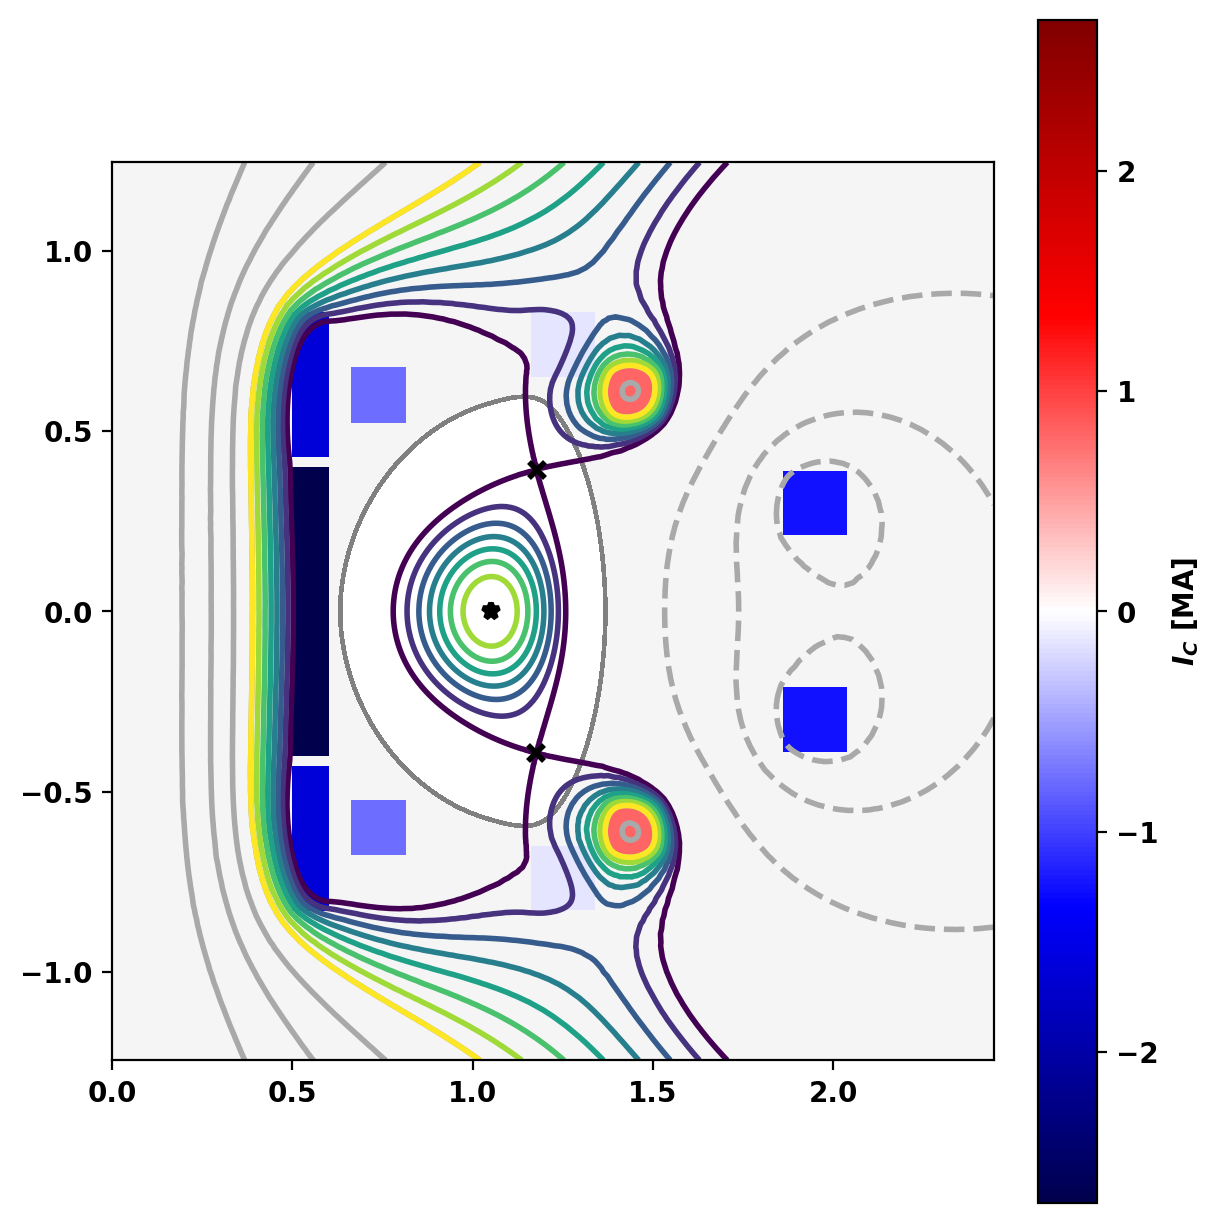

In [ ]:
coil_reg_mat = np.eye(mygs.ncoils+1, dtype=np.float64)
targets = np.zeros(mygs.ncoils+1)
coil_weights = 0.5*np.ones(mygs.ncoils+1)

#Set target values for CS coils
targets[mygs.coil_sets['CS0']['id']] = -1.5E6
targets[mygs.coil_sets['CS1']['id']] = -3.0E6
targets[mygs.coil_sets['CS2']['id']] = -1.5E6

#Enforce up/down symmetry in PF coils using upper coils as the reference
coil_reg_mat[mygs.coil_sets['EF0L']['id'],mygs.coil_sets['EF0U']['id']] = -1.0
coil_weights[mygs.coil_sets['EF0L']['id']] = 1.E1
coil_reg_mat[mygs.coil_sets['EF1L']['id'],mygs.coil_sets['EF1U']['id']] = -1.0
coil_weights[mygs.coil_sets['EF1L']['id']] = 1.E1
coil_reg_mat[mygs.coil_sets['EF2L']['id'],mygs.coil_sets['EF2U']['id']] = -1.0
coil_weights[mygs.coil_sets['EF2L']['id']] = 1.E1
coil_reg_mat[mygs.coil_sets['EF3L']['id'],mygs.coil_sets['EF3U']['id']] = -1.0
coil_weights[mygs.coil_sets['EF3L']['id']] = 1.E1

mygs.set_coil_reg(coil_reg_mat, targets, coil_weights)

#Set upper bound on coil currents
coil_bounds = np.zeros((mygs.ncoils+1,2), dtype=np.float64)
coil_bounds[:,0] = -1.E11; coil_bounds[:,1] = 1.E11
mygs.set_coil_bounds(coil_bounds)

# Define shape of P' and FF' profiles
n_sample = 40
psi_sample = np.linspace(0.0,1.0,n_sample)
# Set F*F' profile
alpha = 2
gamma = 3
ffp_prof = {
    'type': 'linterp',
    'x': psi_sample,
    'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
}
ffp_prof['y'] /= ffp_prof['y'][0] # Normalize profile (not required but convienient)
# Set P' profile
alpha = 2
gamma = 3
pp_prof = {
    'type': 'linterp',
    'x': psi_sample,
    'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
}
pp_prof['y'] /= pp_prof['y'][0] # Normalize profile (not required but convienient)

mygs.set_profiles(ffp_prof=ffp_prof,pp_prof=pp_prof)

# set global targets
Ip_target = 1E6
mygs.set_targets(Ip = Ip_target, Ip_ratio=1.0)

# set boundary/saddle point targets
boundary = create_isoflux(20, 1, 0, 0.2588, 1.5, -0.7)
x_points = np.zeros((2,2))
x_points[0,:] = boundary[np.argmin(boundary[:,1]),:]
x_points[1,:] = boundary[np.argmax(boundary[:,1]),:]
x_weights = 5*np.ones(2)
mygs.set_saddles(x_points, x_weights)
isoflux_weights = 10*np.ones(len(boundary))

mygs.set_isoflux(boundary, isoflux_weights)

#find equilibrium
mygs.init_psi(0.68,0,0.2, 1.8,0.3)
mygs.settings.maxits = 100
mygs.update_settings()
mygs.solve()

#plot equilibrium
fig, ax = plt.subplots(1,1,constrained_layout=True)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_symmap=True,coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]',limiter_color=None)
mygs.plot_psi(fig,ax,vacuum_nlevels=4)

### Extract flux from plasma current only

   1  1.8866E+04


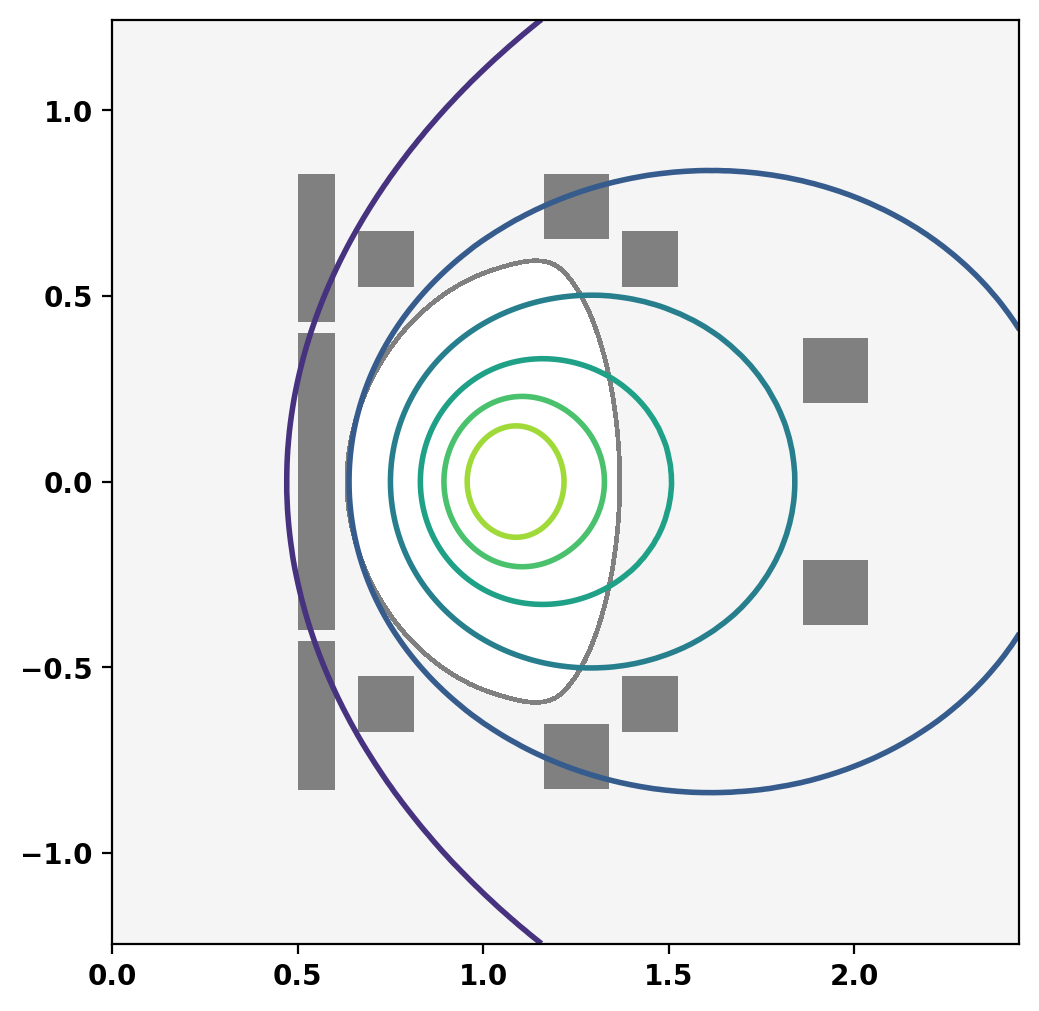

In [ ]:
# Get full flux
psi_full = mygs.get_psi(False)
# Compute flux from coils only
mygs.set_psi(0.0*psi_full)
err_flag = mygs.solve(True)
psi_vac = mygs.get_psi(False)
# Subtract to yield flux from plasma current
psi_plasma = psi_full-psi_vac
# Save coil currents
coil_currents, _ = mygs.get_coil_currents()
# Plot isolated plasma flux
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,limiter_color=None)
mygs.plot_psi(fig,ax,psi_plasma,normalized=False,xpoint_color=None)

### Perform time-dependent simulation with plasma-current quench source


In [ ]:
# Set linear CQ time
CQ_time = 0.65E-3
# Setup simulation
psi_last = np.zeros((mygs.np))
t = 0.0
dt = 0.65E-4
results = [psi_last]
sim_time = [0.0]
mygs.settings.pm=False
mygs.update_settings()
mygs.set_coil_currents(0.0*targets[:-1])
for i in range(120):
    t += dt
    # Set source from last time step w/ or w/o CQ source
    if t <= CQ_time:
        mygs.set_psi_dt(psi_plasma*dt/CQ_time+psi_last,dt)
    else:
        mygs.set_psi_dt(psi_last,dt)
    # Compute next time step
    mygs.set_psi(0.0*psi_last) # Necessary temporarily to initialize zero flux for vacuum solves
    _ = mygs.solve(vacuum=True)
    # Save timestep for plotting
    psi_last = mygs.get_psi(False)
    results.append(psi_last)
    sim_time.append(t)

### Plot results

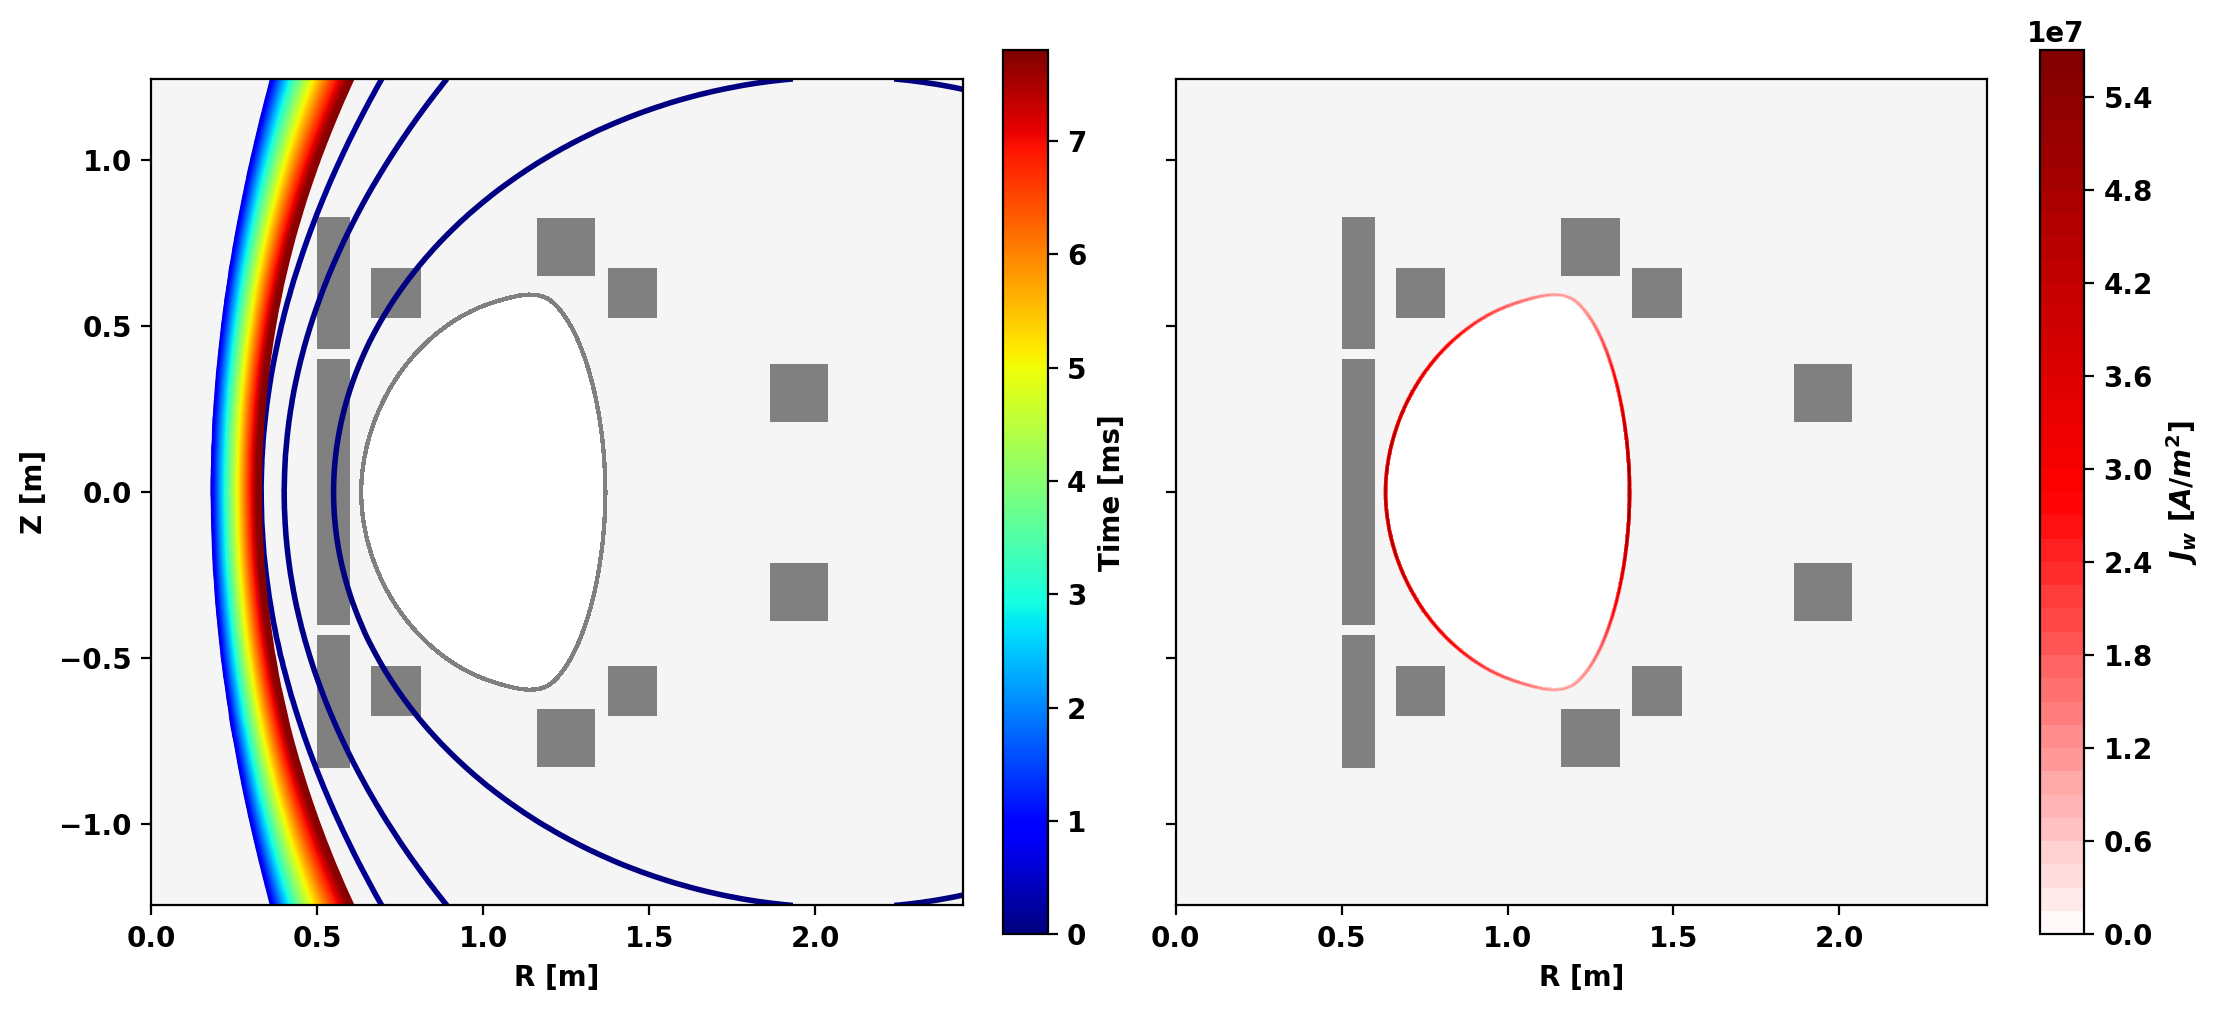

In [ ]:
fig, ax = plt.subplots(1,2,sharey=True,figsize=(11,5),constrained_layout=True)
# Plot flux evolution in time
mygs.plot_machine(fig,ax[0],coil_colormap=None,limiter_color=None)
colors = plt.cm.jet(np.linspace(0, 1, len(results)))
for i, result in enumerate(results[1:]):
    mygs.plot_psi(fig,ax[0],psi=result,normalized=False,plasma_levels=[1.E-2],plasma_color=[colors[i]],vacuum_levels=None,xpoint_color=None)
norm = mpl.colors.Normalize(vmin=0.0, vmax=sim_time[-1]*1.E3)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=plt.cm.jet),ax=ax[0],label='Time [ms]')
ax[0].set_ylabel('Z [m]')
ax[0].set_xlabel('R [m]')
# Plot snapshot at t=10 ms
mygs.plot_machine(fig,ax[1],coil_colormap=None,limiter_color=None)
mygs.plot_eddy(fig,ax[1],psi=results[9],colormap='seismic',symmap=True)
_ = ax[-1].set_xlabel('R [m]')

## Compute forces on VV

In [ ]:
def get_forces(sample_time):
    # Get conductor currents at cell centers
    mask, cond_currents = mygs.get_conductor_currents(results[sample_time],cell_centered=True)
    # Find points inside conducting regions
    pt_mask = np.zeros((mygs.r.shape[0],), dtype=np.int32)
    pt_mask[mygs.lc[mask,:]] = 1
    # Set psi and evaluate B-field in conducting regions
    mygs.set_psi(psi_vac+results[sample_time])
    field_eval = mygs.get_field_eval('B')
    B_cond = np.zeros((mygs.r.shape[0],3))
    for i in range(mygs.r.shape[0]):
        if pt_mask[i] == 0:
            continue
        B_cond[i,:] = field_eval.eval(mygs.r[i,:2])
    Bv_cond = (B_cond[mygs.lc[:,0],:] + B_cond[mygs.lc[:,1],:] + B_cond[mygs.lc[:,2],:])/3.0
    # Get cell centered positions
    rcc = (mygs.r[mygs.lc[:,0],:] + mygs.r[mygs.lc[:,1],:] + mygs.r[mygs.lc[:,2],:])/3.0
    # Return data
    return cond_currents, Bv_cond, mask, rcc

### Plot snapshot at end of CQ

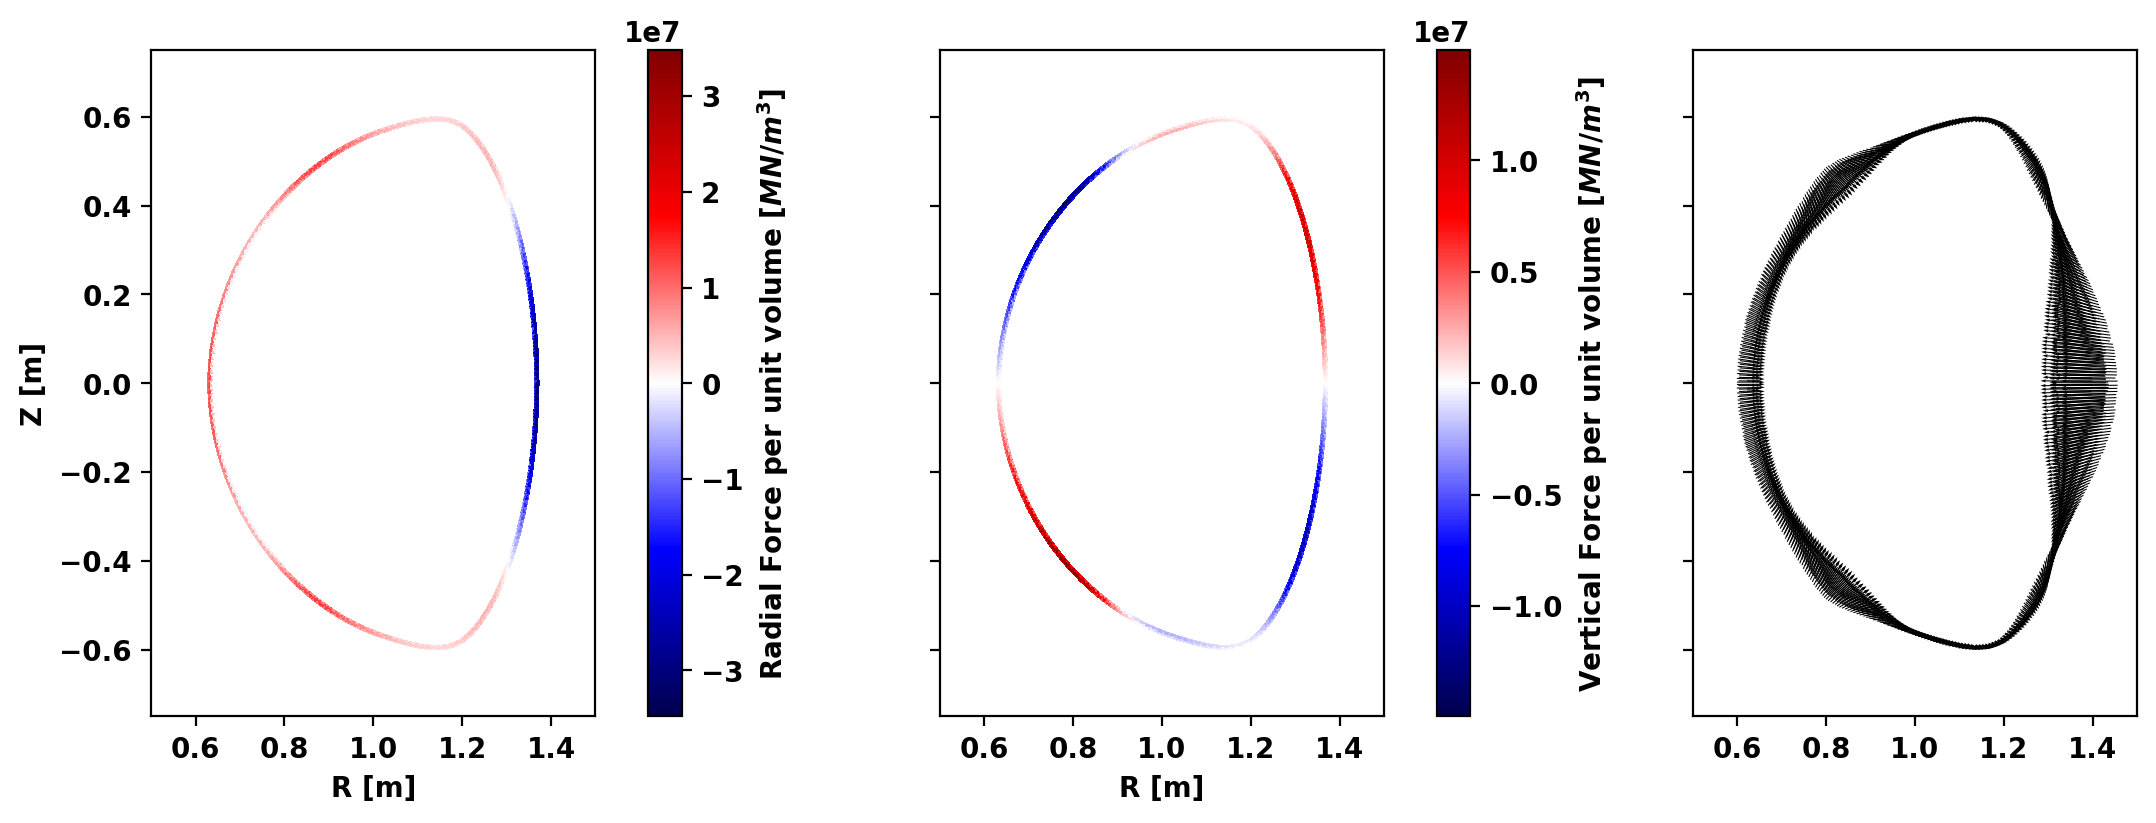

In [ ]:
mesh_currents, Bv_cond, mask, rcc = get_forces(10)

# Plot results
fig, ax = plt.subplots(1,3,figsize=(11,4),sharey=True,constrained_layout=True)
# Radial force
Fr = mesh_currents[mask]*Bv_cond[mask,2]
vmax = abs(Fr).max()
clf = ax[0].tripcolor(mygs.r[:,0],mygs.r[:,1],mygs.lc[mask],Fr,cmap='seismic', vmin=-vmax, vmax=vmax)
fig.colorbar(clf,ax=ax[0],label=r'Radial Force per unit volume [$MN/m^3$]')
ax[0].set_ylabel('Z [m]')
ax[0].set_xlabel('R [m]')
# Vertical force
Fz = -mesh_currents[mask]*Bv_cond[mask,0]
vmax = abs(Fz).max()
clf = ax[1].tripcolor(mygs.r[:,0],mygs.r[:,1],mygs.lc[mask],Fz,cmap='seismic', vmin=-vmax, vmax=vmax)
fig.colorbar(clf,ax=ax[1],label=r'Vertical Force per unit volume [$MN/m^3$]')
_ = ax[1].set_xlabel('R [m]')
ax[0].set_ylim(-0.75,0.75)
# Quiver
ax[2].quiver(rcc[mask,0],rcc[mask,1],Fr,Fz,pivot='middle',scale=2.E8)
for ax_tmp in ax:
    ax_tmp.set_xlim(0.5,1.5)
    ax_tmp.set_aspect('equal','box')

### Generate animation of full quench

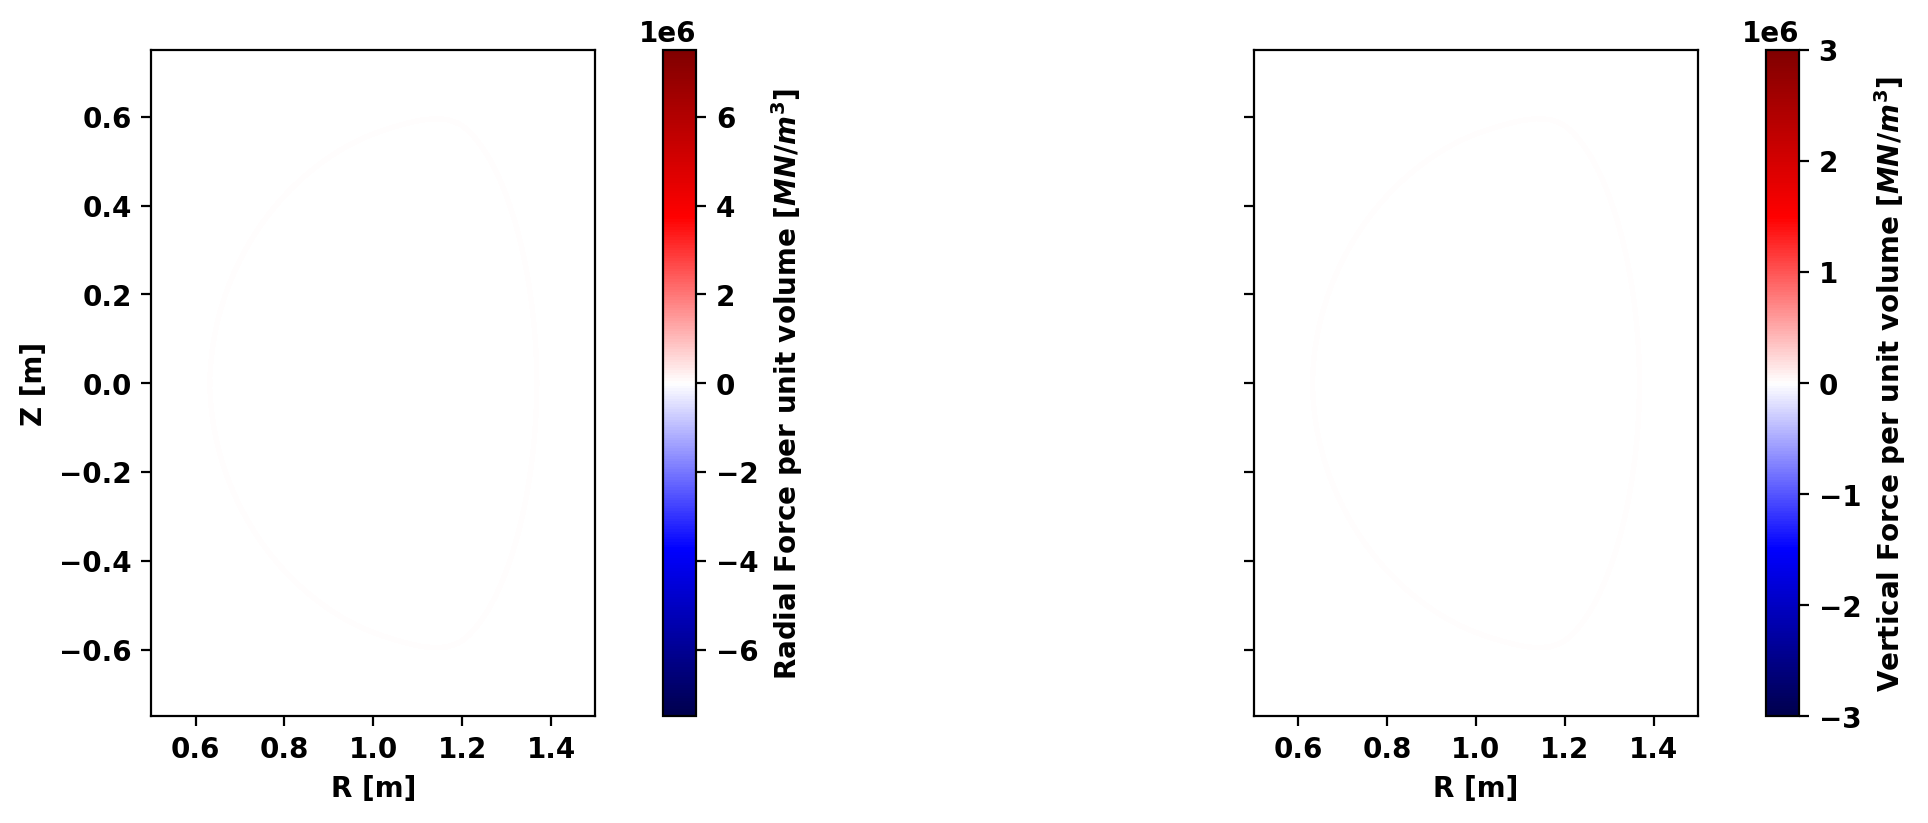

In [ ]:
import matplotlib.animation
from matplotlib.ticker import FuncFormatter
from IPython.display import HTML
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['animation.embed_limit'] = 1.E8

fig, ax = plt.subplots(1,2,figsize=(11,4),sharey=True,constrained_layout=True)
cb1 = None
cb2 = None

#
dV = np.zeros((mygs.nc,))
for i in range(mygs.lc.shape[0]):
    v1 = mygs.r[mygs.lc[i,1],:]-mygs.r[mygs.lc[i,0],:]
    v2 = mygs.r[mygs.lc[i,2],:]-mygs.r[mygs.lc[i,0],:]
    rcc = (mygs.r[mygs.lc[i,2],:]+mygs.r[mygs.lc[i,1],:]+mygs.r[mygs.lc[i,0],:])/3.0
    dV[i] = 2.0*np.pi*rcc[0]*np.linalg.norm(np.cross(v1,v2))/2.0
Fr_net = [0.0 for _ in results]
Fz_net = [0.0 for _ in results]

def animate(i):
    global cb1,cb2
    if cb1 is not None:
        cb1.remove()
    if cb2 is not None:
        cb2.remove()
    for ax_tmp in ax:
        ax_tmp.clear()

    mesh_currents, Bv_cond, mask, rcc = get_forces(i)
    # Radial force
    Fr = mesh_currents[mask]*Bv_cond[mask,2]
    Fr_net[i] = (Fr*dV[mask]).sum()
    vmax = 7.5E6 #abs(Fr).max()
    clf = ax[0].tripcolor(mygs.r[:,0],mygs.r[:,1],mygs.lc[mask],Fr,cmap='seismic', vmin=-vmax, vmax=vmax)
    cb1 = fig.colorbar(clf,ax=ax[0],label=r'Radial Force per unit volume [$MN/m^3$]')
    # Vertical force
    Fz = -mesh_currents[mask]*Bv_cond[mask,0]
    Fz_net[i] = (Fz*dV[mask]).sum()
    vmax = 3.E6 #abs(Fz).max()
    clf = ax[1].tripcolor(mygs.r[:,0],mygs.r[:,1],mygs.lc[mask],Fz,cmap='seismic', vmin=-vmax, vmax=vmax)
    cb2 = fig.colorbar(clf,ax=ax[1],label=r'Vertical Force per unit volume [$MN/m^3$]')
    # Format axes
    ax[0].set_ylabel('Z [m]')
    ax[0].set_ylim(-0.75,0.75)
    for ax_tmp in ax:
        ax_tmp.set_xlim(0.5,1.5)
        ax_tmp.set_xlabel('R [m]')
        ax_tmp.set_aspect('equal','box')

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(results))

# Save as GIF
# writer = matplotlib.animation.PillowWriter(fps=15,
#                                 metadata=dict(artist='Chris Hansen'),
#                                 bitrate=1800)
# ani.save('NT_CQ.gif', writer=writer)

# Save as animation in notebook
HTML(ani.to_jshtml())

### Plot radial force in time

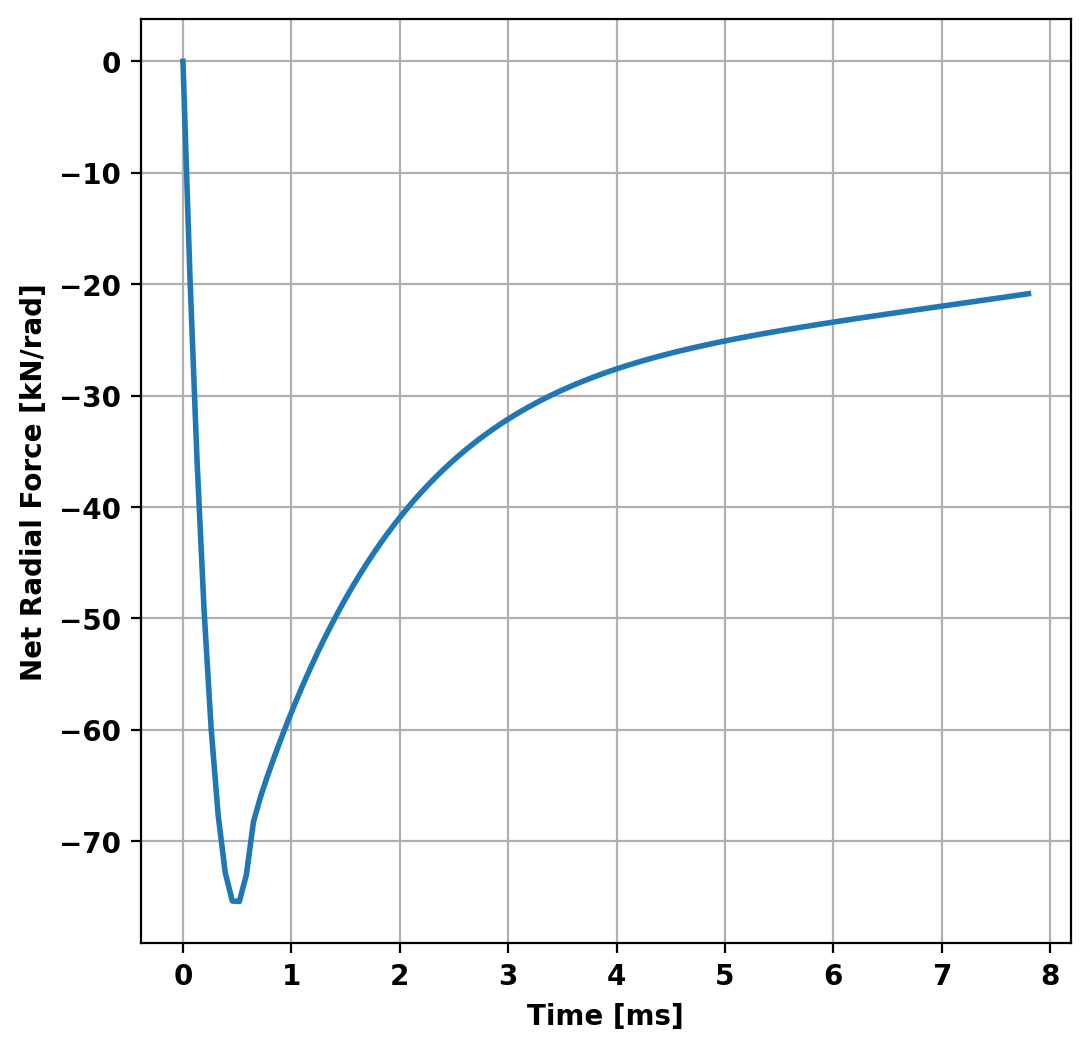

In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot(np.asarray(sim_time)*1.E3,np.asarray(Fr_net)/1.E3/(2.0*np.pi))
ax.grid(True)
ax.set_ylabel(r'Net Radial Force [kN/rad]')
_ = ax.set_xlabel(r'Time [ms]')